In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import shapely.geometry
import pandas as pd
import datetime
import iris
import iris.coord_categorisation

iananmean = iris.analysis.Aggregator('nanmean', np.nanmean)

In [3]:
t2m_all = iris.load_cube('UK_mean_timeseries_t2m_1979_2016.nc')

daycoord = t2m_all[::24].coord('time')
hourcoord = iris.coords.DimCoord(np.arange(24), long_name='hour_of_day', units='hours', circular=True)

/opt/jaspy/lib/python3.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1725: UnknownCellMethodWarning: NetCDF variable 't2m' contains unknown cell method 'nanmean'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)


In [4]:
t2m_reshape = iris.cube.Cube(t2m_all.data.reshape([len(daycoord.points), len(hourcoord.points)]), 
                             long_name=t2m_all.name(), units=t2m_all.units, dim_coords_and_dims=[(daycoord, 0), (hourcoord, 1)])

In [5]:
iris.coord_categorisation.add_day_of_year(t2m_reshape, 'time')
iris.coord_categorisation.add_year(t2m_reshape, 'time')

In [6]:
print(t2m_reshape)

print(t2m_reshape[0, 7].data)
print(t2m_all[7].data)

print(t2m_reshape[10, 10].data)
print(t2m_all[24*10 + 10].data)

2 metre temperature / (K)           (time: 13870; hour_of_day: 24)
     Dimension coordinates:
          time                           x                   -
          hour_of_day                    -                   x
     Auxiliary coordinates:
          day_of_year                    x                   -
          year                           x                   -
267.3597893143872
267.3597893143872
274.700150929442
274.700150929442


In [7]:
t2m_mean = t2m_reshape.collapsed('hour_of_day', iananmean)
t2m_max = t2m_reshape.collapsed('hour_of_day', iris.analysis.MAX)
t2m_min = t2m_reshape.collapsed('hour_of_day', iris.analysis.MIN)
t2m_range = t2m_max - t2m_min

t2m_normalised = (t2m_reshape - t2m_mean)/t2m_range

#t2m_normalised has mean zero, and range 1

/opt/jaspy/lib/python3.7/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'hour_of_day'.
  warnings.warn(msg.format(self.name()))


In [8]:
t2m_seasonal = t2m_normalised.aggregated_by(['day_of_year'], iananmean)

unknown / (1)                       (-- : 366; hour_of_day: 24)
     Dimension coordinates:
          hour_of_day                   -                 x
     Auxiliary coordinates:
          day_of_year                   x                 -
          time                          x                 -
          year                          x                 -
     Cell methods:
          nanmean: day_of_year


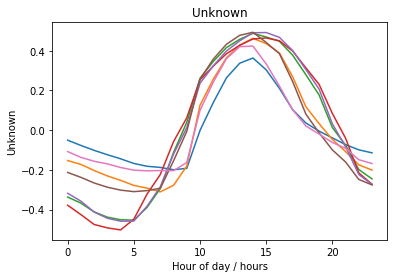

In [9]:
print(t2m_seasonal)
import iris.quickplot as qplt
for i in np.arange(1, 360, 55):
    qplt.plot(t2m_seasonal[i])
plt.show()

In [10]:
case_no = '1'
field = 'T2m'
obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')

In [11]:
# Case 1: 7 days

obs_days = np.reshape(np.array(obs), [7, 24])
obs_dates = np.reshape(obs_date, [7, 24])

monthoffset = [0, 1, -1, 0, 0, 1, 1, 2, 3, 3, 4, 4]
# (monthno-1)*30 + monthoffset + date = day

downscaled_days = np.zeros_like(obs_days)
for i in np.arange(7):
    
    Tmean = np.mean(obs_days[i, :])
    Tmax = np.max(obs_days[i, :])
    Tmin = np.min(obs_days[i, :])
    Trange = Tmax - Tmin
    # extract permitted information: daily mean, daily max, daily min
    
    month = int(str(obs_dates[i, 0])[5:7])
    date = int(str(obs_dates[i, 0])[8:10])
    day = (month-1)*30 + monthoffset[month-1] + date
    
    downscaled_days[i, :] = Tmean + Trange*t2m_seasonal.data[day, :]
    # t2m_seasonal is the mean diurnal cycle over each day of the calendar year for 40 years, with mean zero, and range 1

In [12]:
from eval_case_study_function2 import RMS_based_eval
#from eval_case_study_function import MAE_based_eval

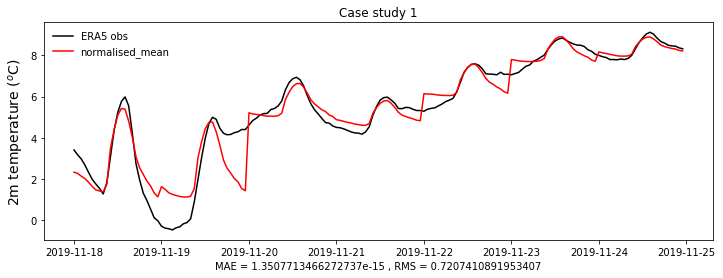

[1.3507713466272737e-15, 0.7207410891953407]

In [13]:
downscale_ts = np.reshape(downscaled_days, [168])
RMS_based_eval(downscale_ts,'T2m','1','normalised_mean')

In [14]:
case_no = '2'
field = 'T2m'
obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')

In [15]:
# Case 2: 9 days
nd = 9

obs_days = np.reshape(np.array(obs), [nd, 24])
obs_dates = np.reshape(obs_date, [nd, 24])

monthoffset = [0, 1, -1, 0, 0, 1, 1, 2, 3, 3, 4, 4]
# (monthno-1)*30 + monthoffset + date = day

downscaled_days2 = np.zeros_like(obs_days)
for i in np.arange(nd):
    
    Tmean = np.mean(obs_days[i, :])
    Tmax = np.max(obs_days[i, :])
    Tmin = np.min(obs_days[i, :])
    Trange = Tmax - Tmin
    # extract permitted information: daily mean, daily max, daily min
    
    month = int(str(obs_dates[i, 0])[5:7])
    date = int(str(obs_dates[i, 0])[8:10])
    day = (month-1)*30 + monthoffset[month-1] + date
    
    downscaled_days2[i, :] = Tmean + Trange*t2m_seasonal.data[day, :]
    # t2m_seasonal is the mean diurnal cycle over each day of the calendar year for 40 years, with mean zero, and range 1

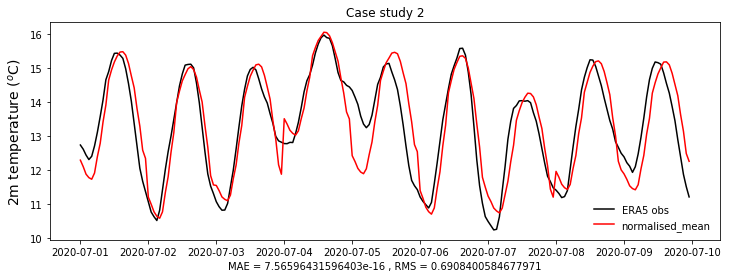

[7.56596431596403e-16, 0.6908400584677971]

In [16]:
downscale_ts = np.reshape(downscaled_days2, [216])
RMS_based_eval(downscale_ts,'T2m','2','normalised_mean')
#print(MAE)
#print(RMS)

In [17]:
case_no = '3'
field = 'T2m'
obs = np.loadtxt('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_' + field + '.dat')
obs_date = np.load('/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_1/case_studies/Case_' + case_no + '_date.npy')

In [18]:
# Case 3: 28 days
nd = 28

obs_days = np.reshape(np.array(obs), [nd, 24])
obs_dates = np.reshape(obs_date, [nd, 24])

monthoffset = [0, 1, -1, 0, 0, 1, 1, 2, 3, 3, 4, 4]
# (monthno-1)*30 + monthoffset + date = day

downscaled_days3 = np.zeros_like(obs_days)
for i in np.arange(nd):
    
    Tmean = np.mean(obs_days[i, :])
    Tmax = np.max(obs_days[i, :])
    Tmin = np.min(obs_days[i, :])
    Trange = Tmax - Tmin
    # extract permitted information: daily mean, daily max, daily min
    
    month = int(str(obs_dates[i, 0])[5:7])
    date = int(str(obs_dates[i, 0])[8:10])
    day = (month-1)*30 + monthoffset[month-1] + date
    
    downscaled_days3[i, :] = Tmean + Trange*t2m_seasonal.data[day, :]
    # t2m_seasonal is the mean diurnal cycle over each day of the calendar year for 40 years, with mean zero, and range 1

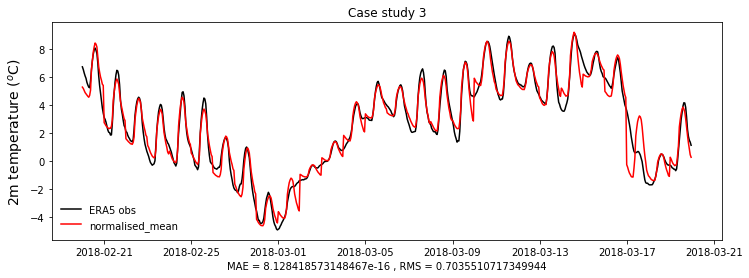

[8.128418573148467e-16, 0.7035510717349944]

In [19]:
downscale_ts = np.reshape(downscaled_days3, [672])
#MAE, RMS = 
RMS_based_eval(downscale_ts,'T2m','3','normalised_mean')
#print(MAE)
#print(RMS)